In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Generate synthetic time series

In [3]:
# generate simple synthetic timeseries that has trend, seasonality and residual components.
# Basically:  a * np.sin(2 * np.pi * t / N) + b * t + noise

np.random.seed(123)



total_points = 365 * 4
time = np.arange(total_points)

# seasonality component
def complex_seasonality(time, configs):
    seasonality = np.zeros_like(time, dtype=float) 
    for amplitude, period, phase_shift in configs:
        seasonality += (amplitude * (np.sin((2 * np.pi * time / period) + phase_shift) + 1)/2 + 0.001*time)**2
        seasonality += amplitude * (np.cos((2 * np.pi * time / period) + phase_shift) + 1)/2

    return seasonality

# config: (amplitude, period, phase_shift)
seasonality_configs = [
    (2, 365/6, 0),  # Main yearly seasonality
    (1, 365/8, np.pi/4),  # Sub-seasonality with a different period and phase
    (0.5, 365/10, np.pi/2),  # Another layer of sub-seasonality
]

seasonality = complex_seasonality(time, seasonality_configs)

# trend component
trend_slope = 0.001
trend = trend_slope * time


# residual component
noise_level = 0.8
residual = np.random.normal(loc=0, scale=noise_level, size=total_points)



In [7]:
df = pd.DataFrame(zip(trend, seasonality, residual), columns=['trend', 'seasonality', 'residual'])
df['DateTime'] = pd.date_range(start='2010-01-01', periods=total_points, freq='D')
df['Value'] = df['trend'] + df['seasonality'] + df['residual']

df


,trend,seasonality,residual,DateTime,Value
0,0.000,5.082107,-0.868504,2010-01-01,4.213602
1,0.001,5.279406,0.797876,2010-01-02,6.078282
2,0.002,5.463582,0.226383,2010-01-03,5.691965
3,0.003,5.631210,-1.205036,2010-01-04,4.429174
4,0.004,5.779161,-0.462880,2010-01-05,5.320280
...,...,...,...,...,...
1455,1.455,14.655923,-0.089676,2013-12-26,16.021247
1456,1.456,15.432413,0.064331,2013-12-27,16.952744
1457,1.457,16.201044,-0.260633,2013-12-28,17.397411
1458,1.458,16.950705,-1.354763,2013-12-29,17.053942


Text(0.5, 1.0, '"Residual" of Synthetic Time Series')

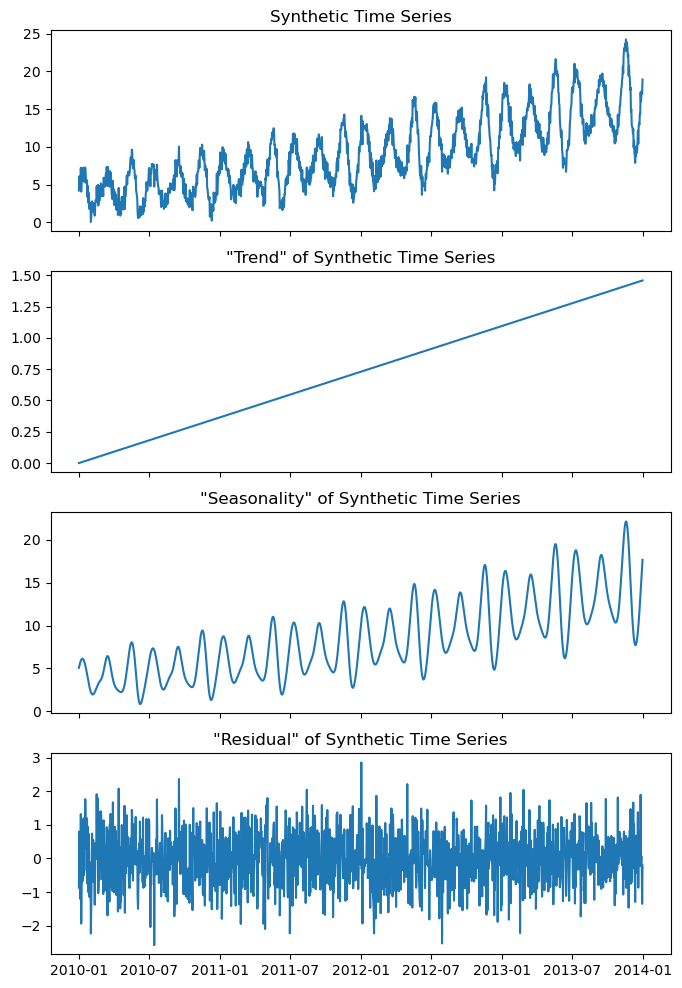

In [13]:
fig, axes = plt.subplots(figsize=(8, 12), nrows=4, ncols=1, sharex=True)

axes[0].plot(df['DateTime'], df['Value'])
axes[0].set_title('Synthetic Time Series')
axes[1].plot(df['DateTime'], df['trend'])
axes[1].set_title('"Trend" of Synthetic Time Series')
axes[2].plot(df['DateTime'], df['seasonality'])
axes[2].set_title('"Seasonality" of Synthetic Time Series')
axes[3].plot(df['DateTime'], df['residual'])
axes[3].set_title('"Residual" of Synthetic Time Series')


#### Apply Box-Cox Transformation on (synthetic) time series

Guerrero: Lambda: 0.9742052228503724
MLE: Lambda: 0.5050862145792977


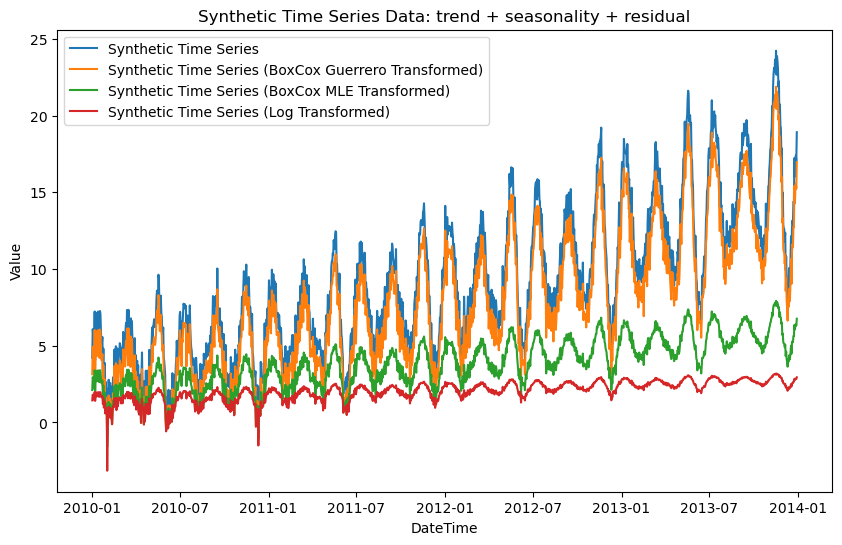

In [5]:
# 1. Forcasting and decomposition methods sometimes work better if the variance is stable across the whole time series
# 2. A BoxCox transform can stabilize the variance, but we need to pick a good value for the parameter Lambda
# 3. The Guerrero method selects Lambda that makes the variace y(lmbda) constant by minimizing the coefficient of variation.
# 4. For Guerrero method, it is important to set split parameter to get the good transofrmation. If we know the seasonality of 
#    data, split parameter is equals to that. If we are not aware of that, it is set to 2 to avoid loosing information.
#    I found it that split parameter can be affected by the noise level in the data!

from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer

gtfr = BoxCoxTransformer(method='guerrero', sp=2) #sp=int(365/4)
df_ts['CBGuerreroTransferedValue'] = gtfr.fit_transform(df_ts['Value'])
print(f'Guerrero: Lambda: {gtfr.lambda_}')


gtfr = BoxCoxTransformer(method='mle')
df_ts['CBMLETransferedValue'] = gtfr.fit_transform(df_ts['Value'])
print(f'MLE: Lambda: {gtfr.lambda_}')

ltfr = LogTransformer()
df_ts['LogTransferedValue'] = ltfr.fit_transform(df_ts['Value'])


#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts['DateTime'], df_ts['Value'], label='Synthetic Time Series')
plt.plot(df_ts['DateTime'], df_ts['CBGuerreroTransferedValue'], label='Synthetic Time Series (BoxCox Guerrero Transformed)')
plt.plot(df_ts['DateTime'], df_ts['CBMLETransferedValue'], label='Synthetic Time Series (BoxCox MLE Transformed)')
plt.plot(df_ts['DateTime'], df_ts['LogTransferedValue'], label='Synthetic Time Series (Log Transformed)')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend + seasonality + residual')
plt.legend()
plt.show()

#### Apply Moving Average on (synthetic) time series

* we might be able to extract the trend using moving average if we are aware of the seasonality. We could choose window size equals to the seasonality and perform moving average to extract trend.
* This approach is, however, not very precise and has limitation such as 1. creating missing values at edges, 2. sensitive to outliers, 3. sensitive to rapid changes

In [6]:
cols = ['DateTime', 'Value']

# compute moving averages
#window_size = 120  # common denomenator of 1/6, 1/8, and 1/10 from synthetic time serie)

def cal_moving_average(df_in: pd.DataFrame, window_size:int) -> pd.DataFrame:
    """ A function that receives input dataframe (with 'DateTime', and 'Value' columns), 
    and returns moving averaged of 'Value' column given window_size. 

    Args:
        df_in (pd.DataFrame): input dataframe that must have 'DateTime', and 'Value' columns
        window_size (int): window size for calculating moving average

    Returns:
        (pd.DataFrame): output dataframe with calculated moving average Value.
    """    
    if window_size % 2 == 0:
        # if window size is even
        movAvgDf = (
            df_in[cols]
            .set_index('DateTime')
            .rolling(
                window=window_size,
                center=False
            ).mean()
            .rolling(
                window=2,
                center=False
            ).mean()
            .shift(
                -window_size//2
            )
        )
    else:
        # if window size is odd
        movAvgDf = (
            df_in[cols]
            .set_index('DateTime')
            .rolling(
                window=window_size,
                center=True
            )
            .mean()
        )

    movAvgDf.rename(columns={'Value':f'{window_size}-MA'}, inplace=True)

    return movAvgDf


window_size_lst = [6, 8, 10, 120]
mvaDF = []
for window_size in window_size_lst:
    mvaDF.append(cal_moving_average(df_ts, window_size))

mvaDF = pd.concat(mvaDF)
mvaDF

,6-MA,8-MA,10-MA,120-MA
DateTime,,,,
2010-01-01,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN
2010-01-04,5.482079,NaN,NaN,NaN
2010-01-05,5.442263,NaN,NaN,NaN
...,...,...,...,...
2013-12-26,NaN,NaN,NaN,NaN
2013-12-27,NaN,NaN,NaN,NaN
2013-12-28,NaN,NaN,NaN,NaN


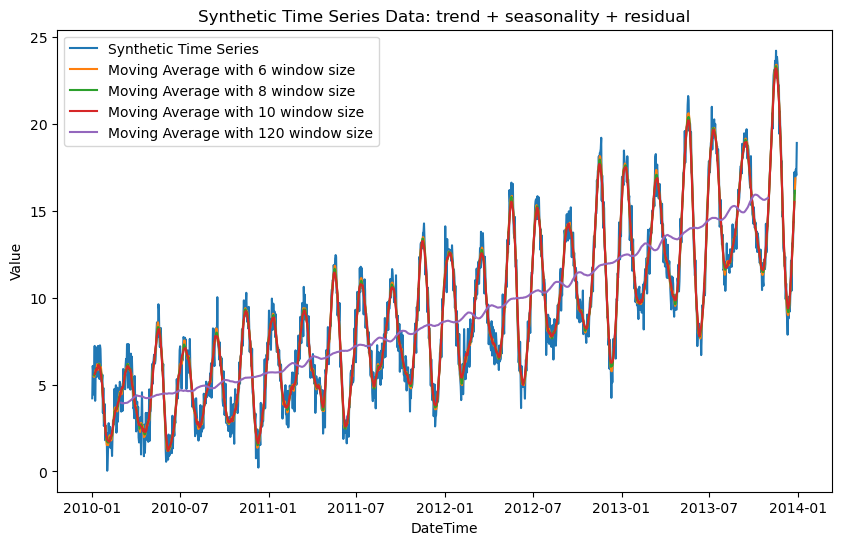

In [7]:
#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts['DateTime'], df_ts['Value'], label='Synthetic Time Series')

for window_size in window_size_lst:
    plt.plot(mvaDF.index, mvaDF[f'{window_size}-MA'], label=f'Moving Average with {window_size} window size')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend + seasonality + residual')
plt.legend()
plt.show()

#### Classical decomposition: Extract seasonality
Seasonality is extracted by de-trending and averaging over a known seasonal index (using moving average technique). This method is NOT reobust to outliers and assumes a fixed seasonal pattern: 

1. Outliers can distort the trend and hence also the estimated seasonal component
2. the classical approach for decomposing seasonality, trend and resdidual, assumes the seasonal component is fixed and does not change with time


**Since in our synthetic time serie, the seasonality is changing (and not fiexed) this apporach is not working on our case study**

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

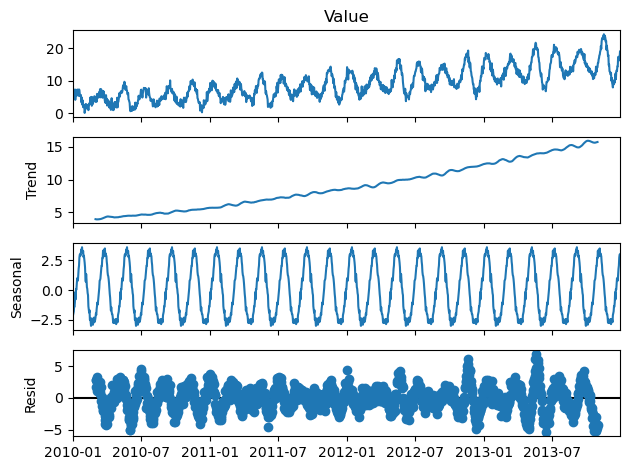

In [9]:
res = seasonal_decompose(
    x=df_ts.set_index('DateTime')['Value'],
    model='additive',
    period=120,
    two_sided=True
)
trend = res.trend
seasonal = res.seasonal
res.plot();

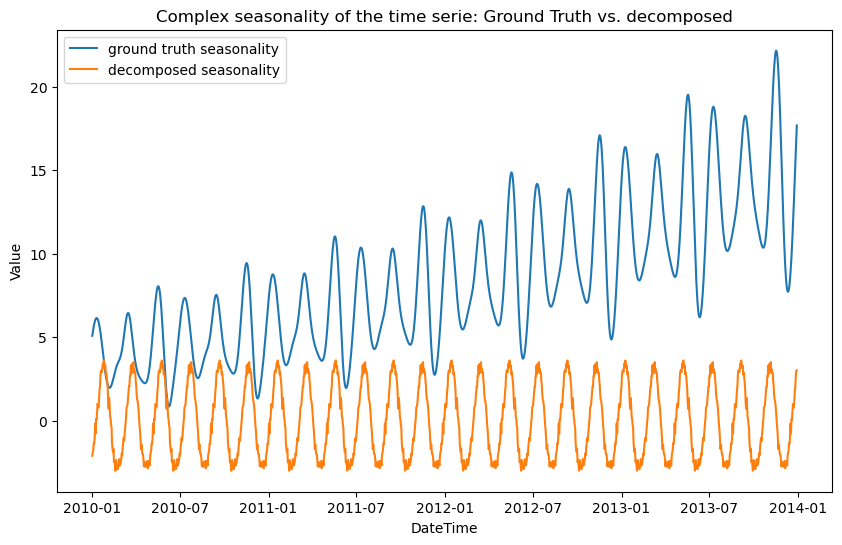

In [10]:
df_seas = pd.DataFrame(seasonality, columns=['Value'])
df_seas['DateTime'] = pd.date_range(start='2010-01-01', periods=total_points, freq='D')
df_seas = df_seas[['DateTime', 'Value']]  # Reordering columns for readability

#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_seas['DateTime'], df_seas['Value'], label='ground truth seasonality')
plt.plot(seasonal, label='decomposed seasonality')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Complex seasonality of the time serie: Ground Truth vs. decomposed')
plt.legend()
plt.show()

#### Extract trend from time series using LOWESS method

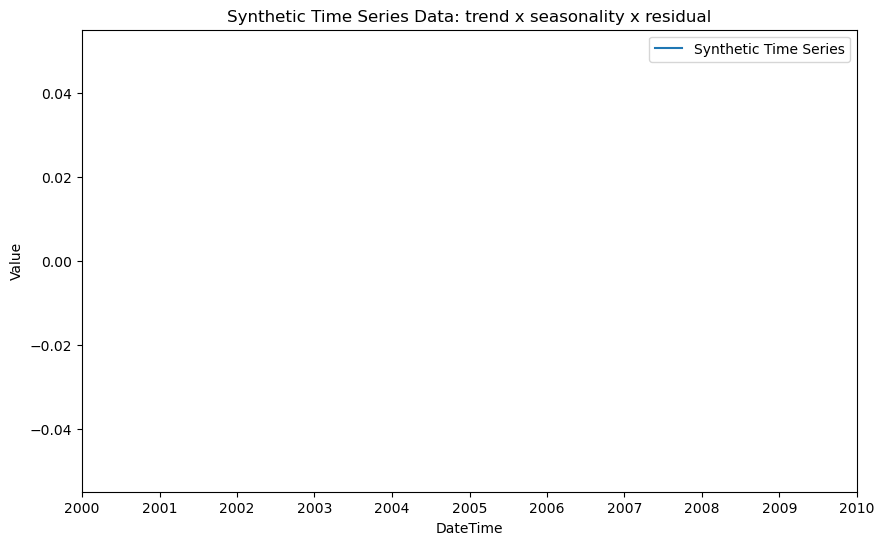

In [11]:
data = trend * seasonality + np.abs(residual)

df_ts2 = pd.DataFrame(data, columns=['Value'])
df_ts2['DateTime'] = pd.date_range(start='2020-01-01', periods=total_points, freq='D')
df_ts2 = df_ts2[['DateTime', 'Value']]  # Reordering columns for readability

#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts2['DateTime'], df_ts2['Value'], label='Synthetic Time Series')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend x seasonality x residual')
plt.legend()
plt.show()

In [12]:
# 1. Forcasting and decomposition methods sometimes work better if the variance is stable across the whole time series
# 2. A BoxCox transform can stabilize the variance, but we need to pick a good value for the parameter Lambda
# 3. The Guerrero method selects Lambda that makes the variace y(lmbda) constant by minimizing the coefficient of variation.
# 4. For Guerrero method, it is important to set split parameter to get the good transofrmation. If we know the seasonality of 
#    data, split parameter is equals to that. If we are not aware of that, it is set to 2 to avoid loosing information.
#    I found it that split parameter can be affected by the noise level in the data!

from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer

gtfr = BoxCoxTransformer(method='guerrero', sp=2) #sp=int(365/4)
df_ts2['CBGuerreroTransferedValue'] = gtfr.fit_transform(df_ts2['Value'])
print(f'Guerrero: Lambda: {gtfr.lambda_}')


gtfr = BoxCoxTransformer(method='mle')
df_ts2['CBMLETransferedValue'] = gtfr.fit_transform(df_ts2['Value'])
print(f'MLE: Lambda: {gtfr.lambda_}')

ltfr = LogTransformer()
df_ts2['LogTransferedValue'] = ltfr.fit_transform(df_ts2['Value'])


#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts2['DateTime'], df_ts2['Value'], label='Synthetic Time Series')
plt.plot(df_ts2['DateTime'], df_ts2['CBGuerreroTransferedValue'], label='Synthetic Time Series (BoxCox Guerrero Transformed)')
plt.plot(df_ts2['DateTime'], df_ts2['CBMLETransferedValue'], label='Synthetic Time Series (BoxCox MLE Transformed)')
plt.plot(df_ts2['DateTime'], df_ts2['LogTransferedValue'], label='Synthetic Time Series (Log Transformed)')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend + seasonality + residual')
plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable